<a href="https://www.kaggle.com/code/nilaygaitonde/email-classifier?scriptVersionId=157283391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeSpamAssassin.csv


In [2]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datasets import load_dataset
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from sklearn.ensemble import VotingClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [3]:
ling = pd.read_csv("/kaggle/input/email-spam-dataset/lingSpam.csv")
enron = pd.read_csv("/kaggle/input/email-spam-dataset/enronSpamSubset.csv")
spamassasin = pd.read_csv("/kaggle/input/email-spam-dataset/completeSpamAssassin.csv")

In [4]:
ling.drop(columns=['Unnamed: 0'],inplace=True)
ling

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1
...,...,...
2600,Subject: computationally - intensive methods i...,0
2601,Subject: books : a survey of american linguist...,0
2602,Subject: wecol ' 98 - - western conference on ...,0
2603,Subject: euralex ' 98 - revised programme\n \n...,0


In [5]:
enron.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
enron

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1
...,...,...
9995,"Subject: monday 22 nd oct\n louise ,\n do you ...",0
9996,Subject: missing bloomberg deals\n stephanie -...,0
9997,Subject: eops salary survey questionnaire\n we...,0
9998,"Subject: q 3 comparison\n hi louise ,\n i have...",0


In [6]:
spamassasin.drop(columns=['Unnamed: 0'],inplace=True)
spamassasin

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1
...,...,...
6041,empty,0
6042,___ ___ ...,0
6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0
6044,empty,0


In [7]:
data = pd.concat([ling,enron,spamassasin],axis=0)
data.reset_index(drop=True,inplace=True)
data

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1
...,...,...
18646,empty,0
18647,___ ___ ...,0
18648,IN THIS ISSUE:01. Readers write\n02. Extension...,0
18649,empty,0


----
Preprocess

In [8]:
data[data['Body']=='empty'].value_counts()
# we can see a lot of empty body values which don't amount to anything thus removing them makes sense

Body   Label
empty  1        335
       0        198
Name: count, dtype: int64

In [9]:
data.drop(data[data['Body']=='empty'].index,inplace=True)

In [10]:
data[data['Body'].apply(lambda x:'-' in str(x) or '_' in str(x))]

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1
...,...,...
18638,----------------------------------------------...,0
18639,"EFFector Vol. 15, No. 35 November ...",0
18644,\nWe have extended our Free seat sale until Th...,0
18647,___ ___ ...,0


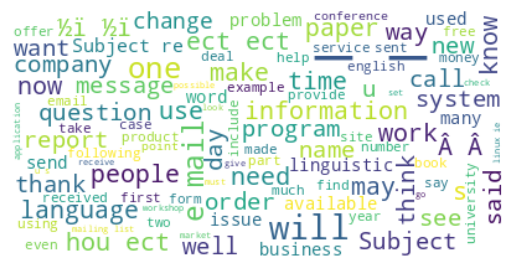

In [11]:
wordcl = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(data['Body'].astype(str)))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
print(data.apply(lambda x:re.search(r'1\s?-\s?888\s?-\s?\d{3}\s?-\s?\d{4}',str(x['Body'])) and x['Label']==0,axis=1).sum(),data.apply(lambda x:re.search(r'1\s?-\s?888\s?-\s?\d{3}\s?-\s?\d{4}',str(x['Body'])) and x['Label']==1,axis=1).sum())
# there is a higher chance of spam emails having phone numbers attached to them

19 52


In [13]:
print(data.apply(lambda x:'thank' in str(x['Body']).lower() and x['Label']==0,axis=1).sum(),data.apply(lambda x:'thank' in str(x['Body']).lower() and x['Label']==1,axis=1).sum())
# thanking you is a personal way touch that spam advertisers usually don't add in their emails

2877 1087


In [14]:
print(data.apply(lambda x:'http://' in str(x['Body']).lower() and x['Label']==0,axis=1).sum(),data.apply(lambda x:'http://' in str(x['Body']).lower() and x['Label']==1,axis=1).sum())
# most of the links are in ham emails so could be another indicator

3114 790


In [15]:
print(data.apply(lambda x:'from' in str(x['Body']).lower() and x['Label']==0,axis=1).sum(),data.apply(lambda x:'from' in str(x['Body']).lower() and x['Label']==1,axis=1).sum())
# we can see that a from email being added is a higher chance of the email being a ham probably because that means it's a reply to some other email

5552 3071


In [16]:
data['Label'].value_counts()

Label
0    11124
1     6994
Name: count, dtype: int64

----
Feature engineering and data preprocessing

In [17]:
def find_html_tags(message):
    return int("<" and ">" in message)

def find_from(message):
    return int("from" in message)

def link_present(message):
    return int("http://" in message)

def num_words(message):
    return len(message)

def signature(message):
    return int("thank" in message)

def keywords_presence(message):
    keywords = ['free', 'offer', 'limited', 'time', 'only', 'discount', 'click', 'buy', 'now', 'order', 'subscribe', 'trial', 'bonus', 'dear', 'friend', 'amazing', 'deal', 'winner', 'lowest', 'price', 'risk', 'money', 'back', 'guarantee', 'congratulations', 'prize', 'winner', 'congrats', 'spam', 'spamming']
    for word in keywords:
        if word in message:
            return int(True)
    return int(False)
        
def num_nums(message):
    return sum(c.isdigit() for c in message)

def num_phone(message):
    if re.search(r'1\s?-\s?888\s?-\s?\d{3}\s?-\s?\d{4}',str(message)):
        return True
    else:
        return False

In [18]:
def clean_text(message,english_stopwords):
    message = message.lower()
    message = re.sub(r'[^\w\s]', '', message)
    message = re.sub(r'[^a-z0-9\s]','',message)
    message = re.sub(r'\d+', '', message)
    message = message.strip()
    message = word_tokenize(message)
    message = [word for word in message if word not in english_stopwords]
    message = [WordNetLemmatizer().lemmatize(word) for word in message]
    message = ' '.join(message)
    return message

In [19]:
def preprocess(df):
    df['Body'] = df['Body'].astype(str)
    df['html_tags'] = df['Body'].apply(find_html_tags)
    df['from'] = df['Body'].apply(find_from)
    df['link'] = df['Body'].apply(link_present)
    df['num_words'] = df['Body'].apply(num_words)
    df['signature'] = df['Body'].apply(signature)
    df['keywords'] = df['Body'].apply(keywords_presence)
    df['num_nums'] = df['Body'].apply(num_nums)
    df['clean_text'] = df['Body'].apply(lambda x:clean_text(english_stopwords=english_stopwords,message=x))
    return df

In [20]:
english_stopwords = stopwords.words('english')
nltk.download('wordnet')
nltk.download('stopwords')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [21]:
vectoriser = TfidfVectorizer(max_features=50000)
df = preprocess(data)

In [22]:
df

,Body,Label,html_tags,from,link,num_words,signature,keywords,num_nums,clean_text
0,Subject: great part-time or summer job !\n \n ...,1,0,1,0,1836,0,1,34,subject great parttime summer job display box ...
1,Subject: auto insurance rates too high ?\n \n ...,1,0,0,0,1252,0,1,11,subject auto insurance rate high dear nlpeople...
2,Subject: do want the best and economical hunti...,1,0,0,0,684,0,1,33,subject want best economical hunting vacation ...
3,Subject: email 57 million people for $ 99\n \n...,1,1,1,0,5234,0,1,151,subject email million people million email add...
4,Subject: do n't miss these !\n \n attention ! ...,1,0,1,0,6652,0,1,157,subject nt miss attention warning adult warnin...
...,...,...,...,...,...,...,...,...,...,...
18638,----------------------------------------------...,0,0,1,1,9342,0,1,158,isilotm palm o pocket pc window enters beta is...
18639,"EFFector Vol. 15, No. 35 November ...",0,1,1,1,9937,0,1,139,effector vol november renefforga publication e...
18644,\nWe have extended our Free seat sale until Th...,0,0,1,1,3417,0,1,66,extended free seat sale thursday st november d...
18647,___ ___ ...,0,0,1,1,16999,1,1,180,oneten insignificant matter heavily overemphas...


In [23]:
tdf_df = vectoriser.fit_transform(data['clean_text']).toarray()

In [24]:
tdf_df.shape

(18118, 50000)

In [25]:
complete_df = np.concatenate((tdf_df,df[['html_tags','from','link','num_words','signature','keywords','num_nums']]),axis=1)
complete_df

array([[  0.,   0.,   0., ...,   0.,   1.,  34.],
       [  0.,   0.,   0., ...,   0.,   1.,  11.],
       [  0.,   0.,   0., ...,   0.,   1.,  33.],
       ...,
       [  0.,   0.,   0., ...,   0.,   1.,  66.],
       [  0.,   0.,   0., ...,   1.,   1., 180.],
       [  0.,   0.,   0., ...,   0.,   1.,  76.]])

In [26]:
X = complete_df
y = data['Label']

In [27]:
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.3)

In [28]:
grid_logreg = {
    'penalty':['l1','l2','elasticnet'],
    'solver':['liblinear','saga']
}
grid_rf = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[10,20,100,200,300],
    'max_features':['log2','sqrt']
}

In [29]:
logreg_best = RandomizedSearchCV(LogisticRegression(),grid_logreg,verbose=2,cv=2,refit=True,scoring='accuracy',return_train_score=True)
logreg_best.fit(train_X,train_y)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .......................penalty=l1, solver=liblinear; total time=   2.3s
[CV] END .......................penalty=l1, solver=liblinear; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............................penalty=l1, solver=saga; total time=10.1min


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............................penalty=l1, solver=saga; total time=10.1min
[CV] END .......................penalty=l2, solver=liblinear; total time=   3.0s
[CV] END .......................penalty=l2, solver=liblinear; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............................penalty=l2, solver=saga; total time= 9.0min


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ............................penalty=l2, solver=saga; total time= 9.0min
[CV] END ...............penalty=elasticnet, solver=liblinear; total time=   0.8s
[CV] END ...............penalty=elasticnet, solver=liblinear; total time=   0.7s
[CV] END ....................penalty=elasticnet, solver=saga; total time=   1.0s
[CV] END ....................penalty=elasticnet, solver=saga; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Only 's

RandomizedSearchCV(cv=2, estimator=LogisticRegression(),
                   param_distributions={'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga']},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [30]:
logreg_best.best_score_,logreg_best.best_params_

(0.9643589339220944, {'solver': 'liblinear', 'penalty': 'l2'})

In [31]:
rf_best = RandomizedSearchCV(RandomForestClassifier(),grid_rf,verbose=2,cv=2,refit=True,scoring='accuracy',return_train_score=True)
rf_best.fit(train_X,train_y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END criterion=entropy, max_depth=100, max_features=log2; total time=   8.6s
[CV] END criterion=entropy, max_depth=100, max_features=log2; total time=   8.4s
[CV] END ...criterion=gini, max_depth=300, max_features=sqrt; total time=  41.2s
[CV] END ...criterion=gini, max_depth=300, max_features=sqrt; total time=  40.9s
[CV] END ....criterion=gini, max_depth=20, max_features=sqrt; total time=  17.6s
[CV] END ....criterion=gini, max_depth=20, max_features=sqrt; total time=  17.6s
[CV] END ....criterion=gini, max_depth=20, max_features=log2; total time=   3.2s
[CV] END ....criterion=gini, max_depth=20, max_features=log2; total time=   3.2s
[CV] END ...criterion=gini, max_depth=100, max_features=sqrt; total time=  38.9s
[CV] END ...criterion=gini, max_depth=100, max_features=sqrt; total time=  38.4s
[CV] END criterion=log_loss, max_depth=200, max_features=sqrt; total time=  38.7s
[CV] END criterion=log_loss, max_depth=200, max

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 100, 200, 300],
                                        'max_features': ['log2', 'sqrt']},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [32]:
rf_best.best_score_,rf_best.best_params_

(0.9715344582873364,
 {'max_features': 'sqrt', 'max_depth': 200, 'criterion': 'log_loss'})

In [33]:
votingClassifier = VotingClassifier(estimators=[('lr',logreg_best.best_estimator_),('nb',MultinomialNB()),('rf',rf_best.best_estimator_)],voting='hard',verbose=2)
votingClassifier.fit(train_X,train_y)

[Voting] ....................... (1 of 3) Processing lr, total=   4.5s
[Voting] ....................... (2 of 3) Processing nb, total=   0.9s
[Voting] ....................... (3 of 3) Processing rf, total= 1.3min


VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('rf',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=200))],
                 verbose=2)

In [34]:
predictions = votingClassifier.predict(test_X)

In [35]:
accuracy_score(test_y,predictions)

0.9729580573951435

In [36]:
confusion_matrix(test_y,predictions)

array([[3293,   29],
       [ 118, 1996]])

In [37]:
def check(message,model,given_df=False):
    df = pd.DataFrame([message], columns=['Body'])
    df = preprocess(df)
    transformed_df = vectoriser.transform(df['clean_text']).toarray()
    complete_df = np.concatenate((transformed_df,df[['html_tags','from','link','num_words','signature','keywords','num_nums']]),axis=1)
    if given_df:
        return complete_df
    else:
        return model.predict(complete_df)

In [38]:
votingClassifier

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('rf',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=200))],
                 verbose=2)

In [39]:
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3322
           1       0.99      0.94      0.96      2114

    accuracy                           0.97      5436
   macro avg       0.98      0.97      0.97      5436
weighted avg       0.97      0.97      0.97      5436



----
Testing

In [40]:
spam_message = """Make it Personal with a Website
Simple. Easy-to-use. Stunning. Creating a personal website has never been more fun.

Dont take our word for it; heres what our friend Harsha G. has to say:
“For my personal brand, this feels like it could be the hub of so many other spokes that come.”

Get started for free, or upgrade to Premium for exclusive templates, a free custom domain for the first year*, and more.


Build my website
Inspiration for your website"""
check(spam_message,votingClassifier)

array([1])

In [41]:
ham_message = """This is ham"""
check(ham_message,votingClassifier)

array([0])

-----
LDA

In [42]:
from sklearn.decomposition import LatentDirichletAllocation

In [43]:
lda = LatentDirichletAllocation(n_components=3,random_state=42)
lda.fit(X[:,:-7])

LatentDirichletAllocation(n_components=3, random_state=42)

In [44]:
X_df = pd.DataFrame(X[:,:-7],columns=vectoriser.get_feature_names_out().tolist())

In [45]:
topic_words = dict()
for topic_idx, topic in enumerate(lda.components_):
    word_idx = topic.argsort()[: -100 :-1]
    topic_words[topic_idx] = [X_df.columns[i] for i in word_idx]
    

In [46]:
topic_words

{0: ['hpl',
  'xl',
  'subject',
  'meter',
  'mmbtu',
  'pill',
  'prescription',
  'price',
  'medication',
  'ect',
  'gas',
  'enron',
  'online',
  'drug',
  'viagra',
  'nom',
  'deal',
  'cialis',
  'logo',
  'med',
  'oo',
  'daren',
  'website',
  'nomination',
  'hou',
  'see',
  'offer',
  'generic',
  'teco',
  'sitara',
  'actuals',
  'software',
  'business',
  'tap',
  'utf',
  'pharmacy',
  'volume',
  'attached',
  'tab',
  'soft',
  'stationery',
  'watch',
  'hplno',
  'stop',
  'rolex',
  'delivery',
  'pain',
  'daily',
  'company',
  'cheap',
  'file',
  'ami',
  'xanax',
  'noms',
  'com',
  'need',
  'flow',
  'hplo',
  'brand',
  'rx',
  'toner',
  'shipping',
  'http',
  'doctor',
  'quality',
  'site',
  'norton',
  'best',
  'fuel',
  'door',
  'cartridge',
  'ciick',
  'dose',
  'submit',
  'tablet',
  'click',
  'search',
  'save',
  'chokshi',
  'effective',
  'competitor',
  'hot',
  'wysak',
  'valium',
  'aimee',
  'promotional',
  'relief',
  'farmer'

Topic 1


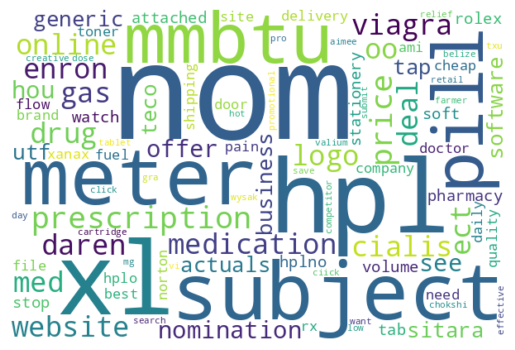

Topic 2


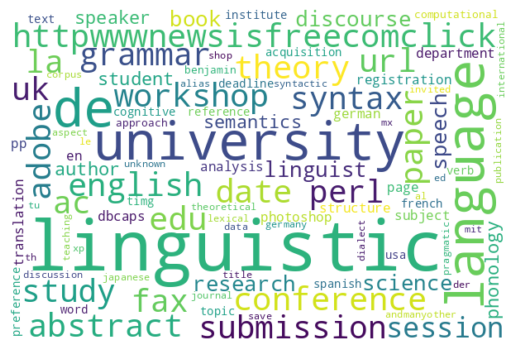

Topic 3


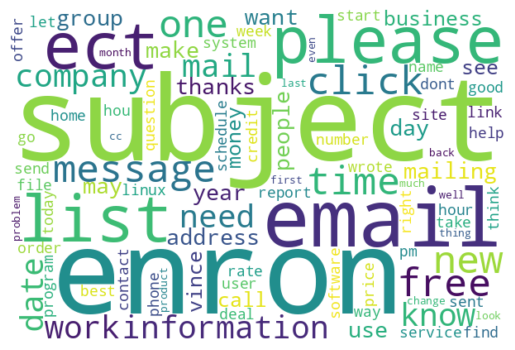

In [47]:
for topic_id, words in topic_words.items():
    print(f"Topic {topic_id+1}")
    wc = WordCloud(width=600, height=400, background_color="white")
    plt.imshow(wc.generate(" ".join(words)), interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [48]:
df = check(spam_message,model=votingClassifier,given_df=True)
df = df[:,:-7]
topics = lda.transform(df)
for i in range(len(topics[0])):
    if topics[0][i]>0.3:
        print(f"topic no. {i}")
    else:
        pass

topic no. 2
